In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Descargar dataset Animal Faces**

In [ ]:
import kagglehub

# Descargar la última versión del dataset Animal Faces
path = kagglehub.dataset_download("andrewmvd/animal-faces")
print("Ruta a los archivos del dataset:", path)

# **Generador**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Rutas a carpetas de train y val
train_dir = '/kaggle/input/animal-faces/afhq/train'
val_dir = '/kaggle/input/animal-faces/afhq/val'

# Generador con aumentos y preprocesamiento para entrenamiento
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Generador solo con preprocesamiento para validación (sin aumentos)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

# Generador de validación
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(512, 512),
    batch_size=32,
    class_mode='categorical'
)

# **Entrenar el modelo**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Cargar ResNet50 sin la capa superior (sin clasificación)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

# Congelar las capas del modelo base para que no se entrenen inicialmente
base_model.trainable = False

# Añadir capas personalizadas para clasificación
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)  # 3 clases: cat, dog, wild

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=output)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Mostrar resumen
model.summary()

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

In [ ]:
model.save('modelo_resnet50_etapa1.keras')  # Después del entrenamiento inicial

# **Fine tuning**

## **Seguido**

In [ ]:
# ---- Segunda fase: Fine tuning ----
# Descongelar el modelo base
base_model.trainable = True

# Congelar todas las capas excepto las últimas 50 para evitar desajustes
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Recompilar con learning rate más bajo para fine tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continuar entrenamiento con fine tuning
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,  # total epochs: 10 + 15 = 25
    initial_epoch=history.epoch[-1] + 1
)

In [ ]:
model.save('modelo_resnet50_finetuned.h5')  # Después del fine-tuning

## **Por partes**

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# 1. Cargar el modelo guardado (del primer entrenamiento)
model = load_model('modelo_resnet50_etapa1.keras')

# 2. Desbloquear todas las capas para preparar el fine-tuning
model.trainable = True

# 3. Congelar todas las capas excepto las últimas 50
for layer in model.layers[:-50]:
    layer.trainable = False

# 4. Recompilar con un learning rate más bajo para fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 5. Continuar el entrenamiento con fine-tuning
#    Recuerda ajustar 'initial_epoch' al número de épocas ya entrenadas en la primera fase.
initial_epoch = 10  # Cambia según cuántas épocas entrenaste antes

fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,          # total epochs deseadas (por ejemplo 25)
    initial_epoch=initial_epoch
)

In [ ]:
model.save('modelo_resnet50_finetuned.h5')  # Después del fine-tuning

# **Evaluar modelo**

In [ ]:
# Evaluar modelo
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Precisión en validación: {val_acc*100:.2f}%")


In [ ]:
# Obtener predicciones en el conjunto de validación
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
# Etiquetas reales del generador
y_true = validation_generator.classes
class_names = list(validation_generator.class_indices.keys())

In [ ]:
from sklearn.metrics import classification_report

print("Reporte de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

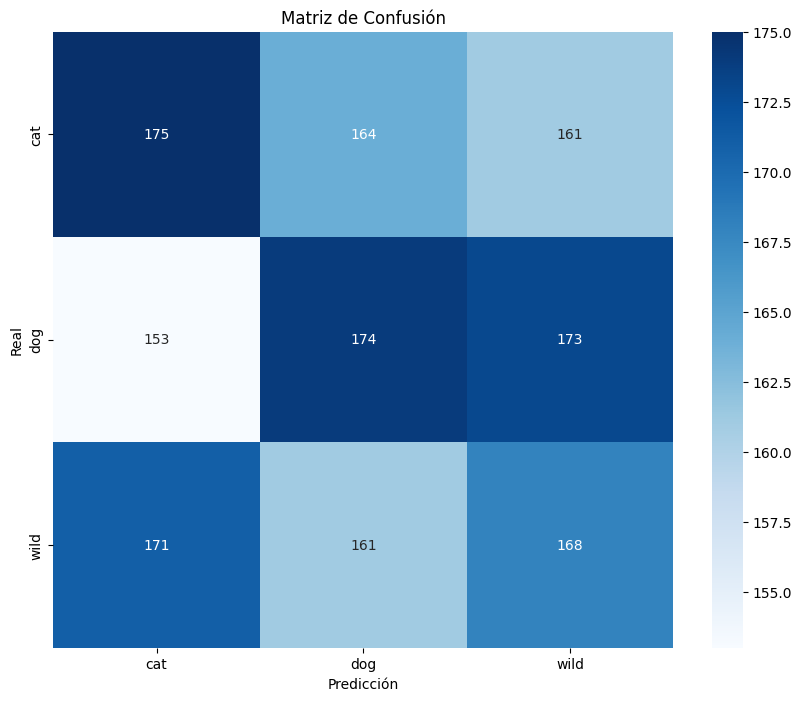

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()
